# UCI regression eval

In [1]:
import os
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [288]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

plt.rcParams["font.size"] = 18

cmap = {
    "EKF-IW": "crimson",
    "WLF-IMQ": "dodgerblue",
    "EKF": "lightseagreen",
    "WLF-MD": "gold",
    "OGD": "blueviolet",
    "EKF-B": "darkorange",
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [314]:
from matplotlib import colors
cmap_rgb = {
    c: colors.cnames[v]
    for c, v in cmap.items()
}
cmap_rgb

{'EKF-IW': '#DC143C',
 'WLF-IMQ': '#1E90FF',
 'EKF': '#20B2AA',
 'WLF-MD': '#FFD700',
 'OGD': '#8A2BE2',
 'EKF-B': '#FF8C00'}

In [205]:
path_base = "./results"
# experiment_names = [f for f in os.listdir(path_base) if ("-target" in f) and ("p-error" not in f)]
experiment_names = [f for f in os.listdir(path_base) if ("-target" in f) and ("p-error10" in f)]
sorted(experiment_names)

['bostonHousing-target-p-error10.pkl',
 'concrete-target-p-error10.pkl',
 'energy-target-p-error10.pkl',
 'kin8nm-target-p-error10.pkl',
 'naval-propulsion-plant-target-p-error10.pkl',
 'power-plant-target-p-error10.pkl',
 'protein-tertiary-structure-target-p-error10.pkl',
 'wine-quality-red-target-p-error10.pkl',
 'yacht-target-p-error10.pkl']

In [206]:
info_datasets = []
uci = datagen.UCIDatasets("./data")
for dataset_name in sorted(uci.datasets, key=lambda x: -len(x)):
    dataset = uci.load_dataset(dataset_name)
    nrows, ncols = dataset.shape
    
    info_datasets.append({
        "dataset": dataset_name.split("-")[0].capitalize(),
        "nrows": nrows,
        "ncols": ncols
    })

info_datasets = pd.DataFrame(info_datasets).sort_values("dataset")
info_datasets

,dataset,nrows,ncols
3,Bostonhousing,507,14
5,Concrete,1031,9
6,Energy,769,9
7,Kin8nm,8193,9
1,Naval,11935,18
4,Power,9569,5
0,Protein,45731,10
2,Wine,1600,12
8,Yacht,309,7


In [207]:
df_results_all = []
for file_name in experiment_names:
    dataset = file_name.replace("-target.pkl", "")
    path = os.path.join(path_base, file_name)
    with open(path, "rb") as f:
        experiment = pickle.load(f)

    errors = experiment["methods"]
    
    running_times = experiment["running-times"].copy()
    # del running_times["EKF-B"]    # REMOVE AFTER REFACTORING
    running_times = pd.DataFrame(running_times)

    df_results = pd.DataFrame({
        name: errors[name].median(axis=0)
        for name in errors
    })

    df_results = df_results.reset_index().melt("index", value_name="err")
    running_times = running_times.reset_index().melt("index", value_name="time")
    
    df_results = pd.merge(
        df_results,
        running_times,
        on=["index", "variable"],
    )
    
    df_results["dataset"] = dataset
    df_results_all.append(df_results)

df_results_all = pd.concat(df_results_all, axis=0)

# Root median squared error
df_results_all["err"] = np.sqrt(df_results_all["err"])
df_results_all["dataset"] = df_results_all["dataset"].str.replace("-.*", "", regex=True).str.capitalize()
df_results_all = df_results_all.merge(info_datasets, on="dataset")

In [208]:
df_results_all["timestep"] = df_results_all["time"] / (df_results_all["nrows"]) * 1e6

In [209]:
datasets = sorted(df_results_all.dataset.unique())
print(datasets)

['Bostonhousing', 'Concrete', 'Energy', 'Kin8nm', 'Naval', 'Power', 'Protein', 'Wine', 'Yacht']


In [210]:
info_datasets

,dataset,nrows,ncols
3,Bostonhousing,507,14
5,Concrete,1031,9
6,Energy,769,9
7,Kin8nm,8193,9
1,Naval,11935,18
4,Power,9569,5
0,Protein,45731,10
2,Wine,1600,12
8,Yacht,309,7


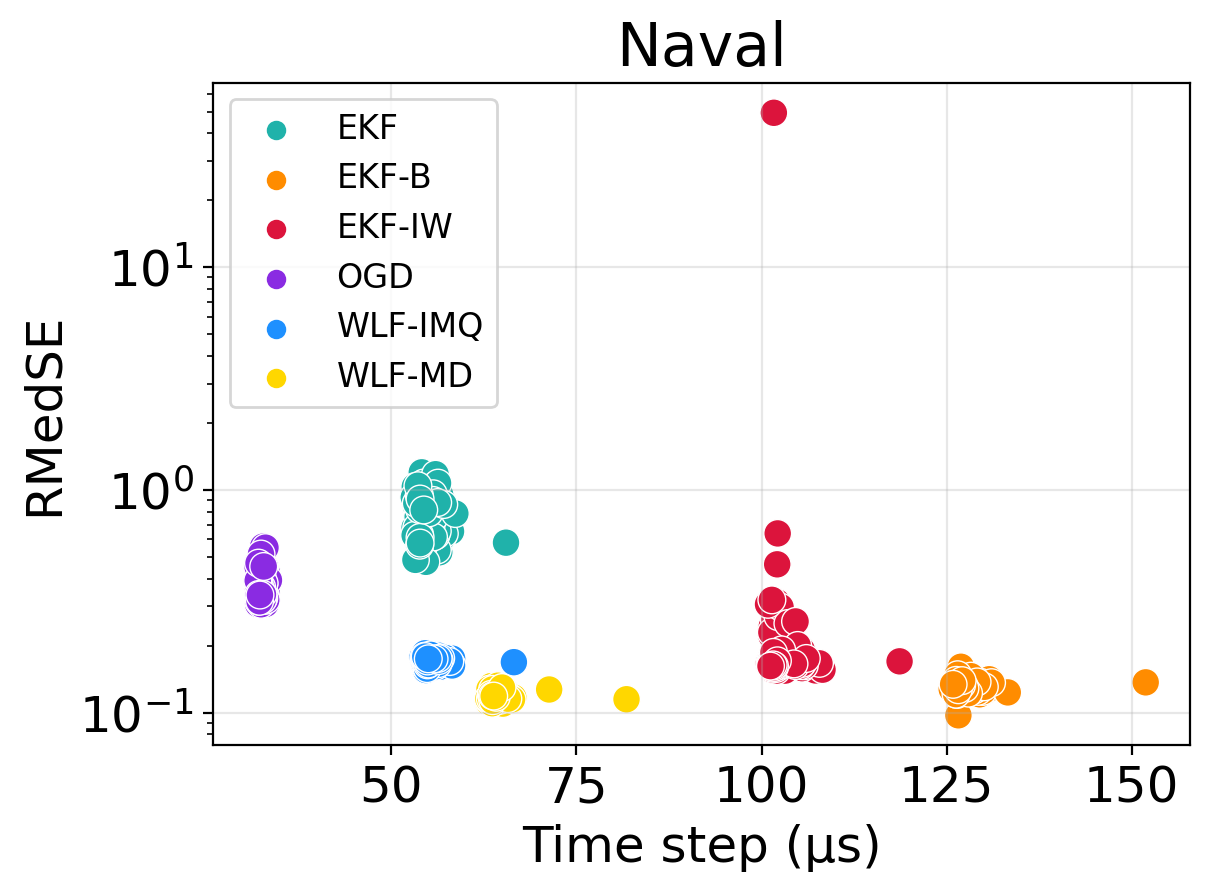

In [293]:
algorithms = sorted(cmap.keys())

dataset = "Naval"
sns.scatterplot(
    y="err", x="timestep", hue="variable",
    data=df_results_all.query("dataset == @dataset").query("err < 10 ** 2"),
    palette=cmap, s=100,
    hue_order=algorithms,
    linewidth=0.5
)
plt.yscale("log")
plt.legend(ncol=1, loc="upper left", fontsize=12)
plt.title(dataset)
plt.xlabel("Time step (μs)")
plt.ylabel("RMedSE")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f"./figures/{dataset.lower()}-time-v-err.png", dpi=300)

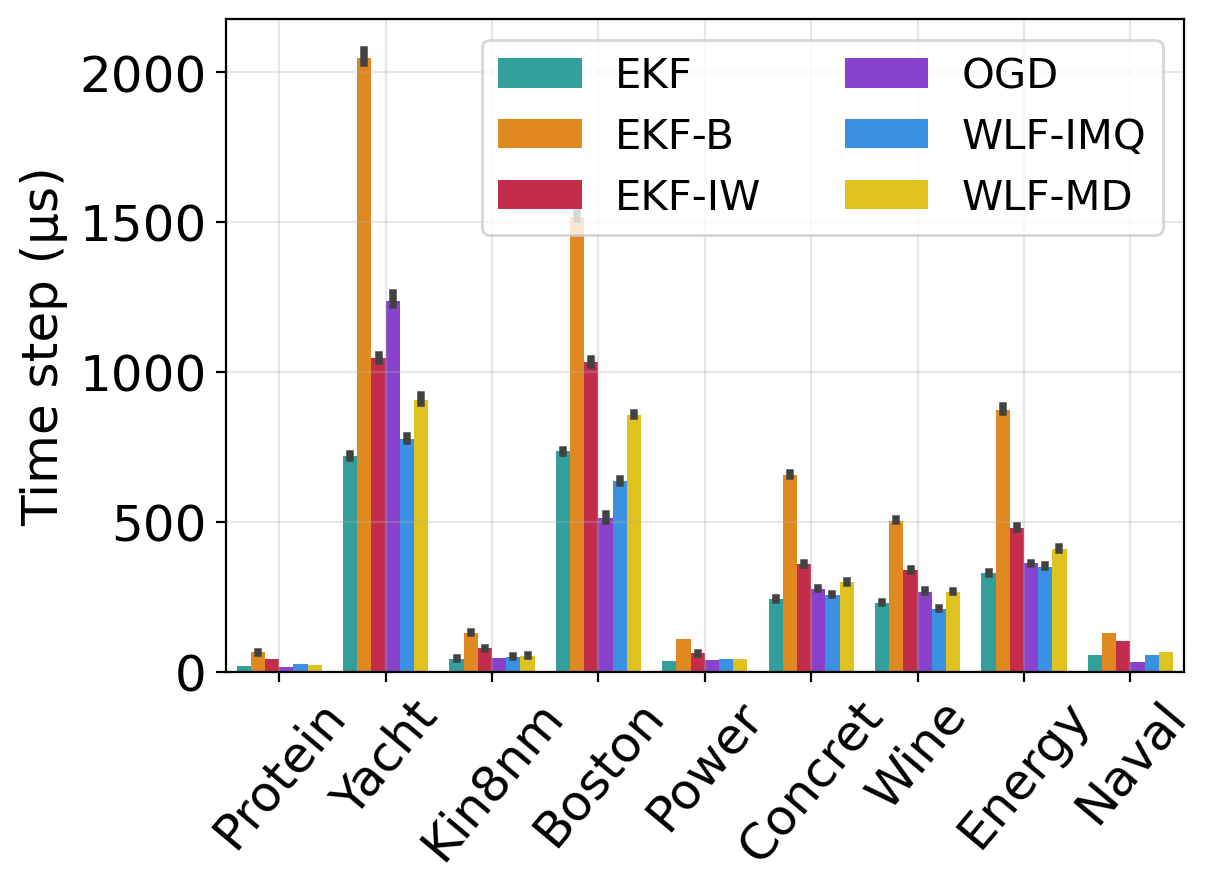

In [305]:
sns.barplot(
    x="dataset",
    y="timestep",
    hue="variable",
    palette=cmap,
    data=(
        df_results_all.assign(dataset=df_results_all.dataset.str[:7].str.replace("nh", "n"))
    ),
)
plt.legend(ncol=2, fontsize=15)
plt.xticks(rotation=50)
plt.grid(alpha=0.3)
plt.xlabel("")
plt.ylabel("Time step (μs)")
plt.tight_layout()
plt.savefig(f"./figures/uci-time-comparison.png", dpi=300)

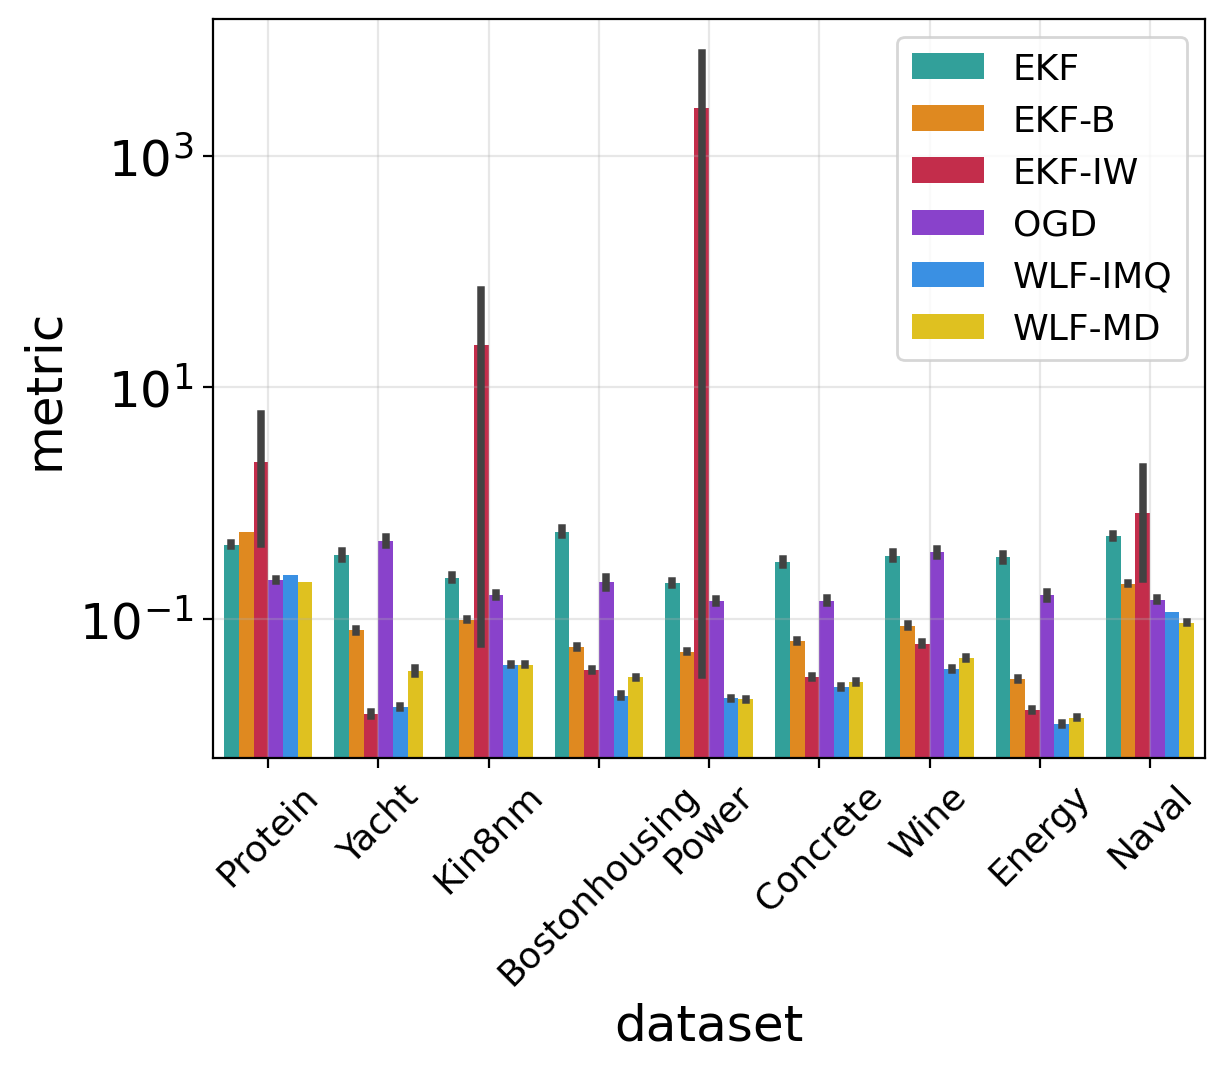

In [304]:
sns.barplot(
    x="dataset",
    y="metric",
    hue="variable",
    palette=cmap,
    data=df_results_all.assign(metric=df_results_all["err"] * df_results_all["time"]),
)
plt.legend(ncol=1, fontsize=13)
plt.xticks(rotation=45, fontsize=13)
plt.grid(alpha=0.3)
plt.yscale("log")

In [283]:
def format_entry(entry):
    # entry = entry[entry < 1000]
    mean = entry.mean()
    std = entry.std()
    if std > 1000:
        label = rf"$-$"
    else:
        label = rf"${mean:0.2f} \pm {std:0.2f}$"
    return label

In [284]:
res = (
    df_results_all
    .pivot_table(columns="variable", index="dataset", values="err", aggfunc=format_entry)
)
res

variable,EKF,EKF-B,EKF-IW,OGD,WLF-IMQ,WLF-MD
dataset,,,,,,
Bostonhousing,$1.51 \pm 0.53$,$0.07 \pm 0.01$,$0.07 \pm 0.01$,$0.80 \pm 0.42$,$0.07 \pm 0.01$,$0.07 \pm 0.01$
Concrete,$1.24 \pm 0.38$,$0.09 \pm 0.01$,$0.08 \pm 0.01$,$0.50 \pm 0.15$,$0.10 \pm 0.01$,$0.09 \pm 0.01$
Energy,$1.34 \pm 0.44$,$0.04 \pm 0.00$,$0.04 \pm 0.00$,$0.57 \pm 0.21$,$0.05 \pm 0.00$,$0.04 \pm 0.00$
Kin8nm,$0.63 \pm 0.15$,$0.09 \pm 0.00$,$37.02 \pm 364.32$,$0.43 \pm 0.09$,$0.10 \pm 0.00$,$0.09 \pm 0.00$
Naval,$0.78 \pm 0.16$,$0.13 \pm 0.01$,$0.68 \pm 4.92$,$0.38 \pm 0.06$,$0.17 \pm 0.01$,$0.12 \pm 0.01$
Power,$0.58 \pm 0.13$,$0.05 \pm 0.00$,$-$,$0.38 \pm 0.07$,$0.05 \pm 0.00$,$0.05 \pm 0.00$
Protein,$0.48 \pm 0.08$,$0.19 \pm 0.00$,$1.16 \pm 8.82$,$0.33 \pm 0.03$,$0.21 \pm 0.00$,$0.19 \pm 0.00$
Wine,$0.95 \pm 0.31$,$0.11 \pm 0.01$,$0.11 \pm 0.01$,$0.87 \pm 0.33$,$0.11 \pm 0.01$,$0.11 \pm 0.01$
Yacht,$1.60 \pm 0.60$,$0.13 \pm 0.02$,$0.05 \pm 0.01$,$1.22 \pm 0.45$,$0.07 \pm 0.01$,$0.12 \pm 0.02$


In [286]:
print(res.style.to_latex(hrules=True).replace("_", "-"))

\begin{tabular}{lllllll}
\toprule
variable & EKF & EKF-B & EKF-IW & OGD & WLF-IMQ & WLF-MD \\
dataset &  &  &  &  &  &  \\
\midrule
Bostonhousing & $1.51 \pm 0.53$ & $0.07 \pm 0.01$ & $0.07 \pm 0.01$ & $0.80 \pm 0.42$ & $0.07 \pm 0.01$ & $0.07 \pm 0.01$ \\
Concrete & $1.24 \pm 0.38$ & $0.09 \pm 0.01$ & $0.08 \pm 0.01$ & $0.50 \pm 0.15$ & $0.10 \pm 0.01$ & $0.09 \pm 0.01$ \\
Energy & $1.34 \pm 0.44$ & $0.04 \pm 0.00$ & $0.04 \pm 0.00$ & $0.57 \pm 0.21$ & $0.05 \pm 0.00$ & $0.04 \pm 0.00$ \\
Kin8nm & $0.63 \pm 0.15$ & $0.09 \pm 0.00$ & $37.02 \pm 364.32$ & $0.43 \pm 0.09$ & $0.10 \pm 0.00$ & $0.09 \pm 0.00$ \\
Naval & $0.78 \pm 0.16$ & $0.13 \pm 0.01$ & $0.68 \pm 4.92$ & $0.38 \pm 0.06$ & $0.17 \pm 0.01$ & $0.12 \pm 0.01$ \\
Power & $0.58 \pm 0.13$ & $0.05 \pm 0.00$ & $-$ & $0.38 \pm 0.07$ & $0.05 \pm 0.00$ & $0.05 \pm 0.00$ \\
Protein & $0.48 \pm 0.08$ & $0.19 \pm 0.00$ & $1.16 \pm 8.82$ & $0.33 \pm 0.03$ & $0.21 \pm 0.00$ & $0.19 \pm 0.00$ \\
Wine & $0.95 \pm 0.31$ & $0.11 \pm 0.01$ & 

In [287]:
(
    df_results_all
    .pivot_table(columns="variable", index="dataset", values="err", aggfunc=lambda x: (x > 1000).sum())
)

variable,EKF,EKF-B,EKF-IW,OGD,WLF-IMQ,WLF-MD
dataset,,,,,,
Bostonhousing,0,0,0,0,0,0
Concrete,0,0,0,0,0,0
Energy,0,0,0,0,0,0
Kin8nm,0,0,1,0,0,0
Naval,0,0,0,0,0,0
Power,0,0,1,0,0,0
Protein,0,0,0,0,0,0
Wine,0,0,0,0,0,0
Yacht,0,0,0,0,0,0


## Experiments

In [21]:
sorted(experiment_names)

['bostonHousing-target-p-error10.pkl',
 'concrete-target-p-error10.pkl',
 'energy-target-p-error10.pkl',
 'kin8nm-target-p-error10.pkl',
 'naval-propulsion-plant-target-p-error10.pkl',
 'power-plant-target-p-error10.pkl',
 'protein-tertiary-structure-target-p-error10.pkl',
 'wine-quality-red-target-p-error10.pkl',
 'yacht-target-p-error10.pkl']

In [37]:
targets = [
    "concrete-target-p-error10.pkl",
    "kin8nm-target-p-error10.pkl",
    "naval-propulsion-plant-target-p-error10.pkl",
    "power-plant-target-p-error10.pkl",
]

In [38]:
algorithms = errors.keys()
algorithms = sorted(algorithms)

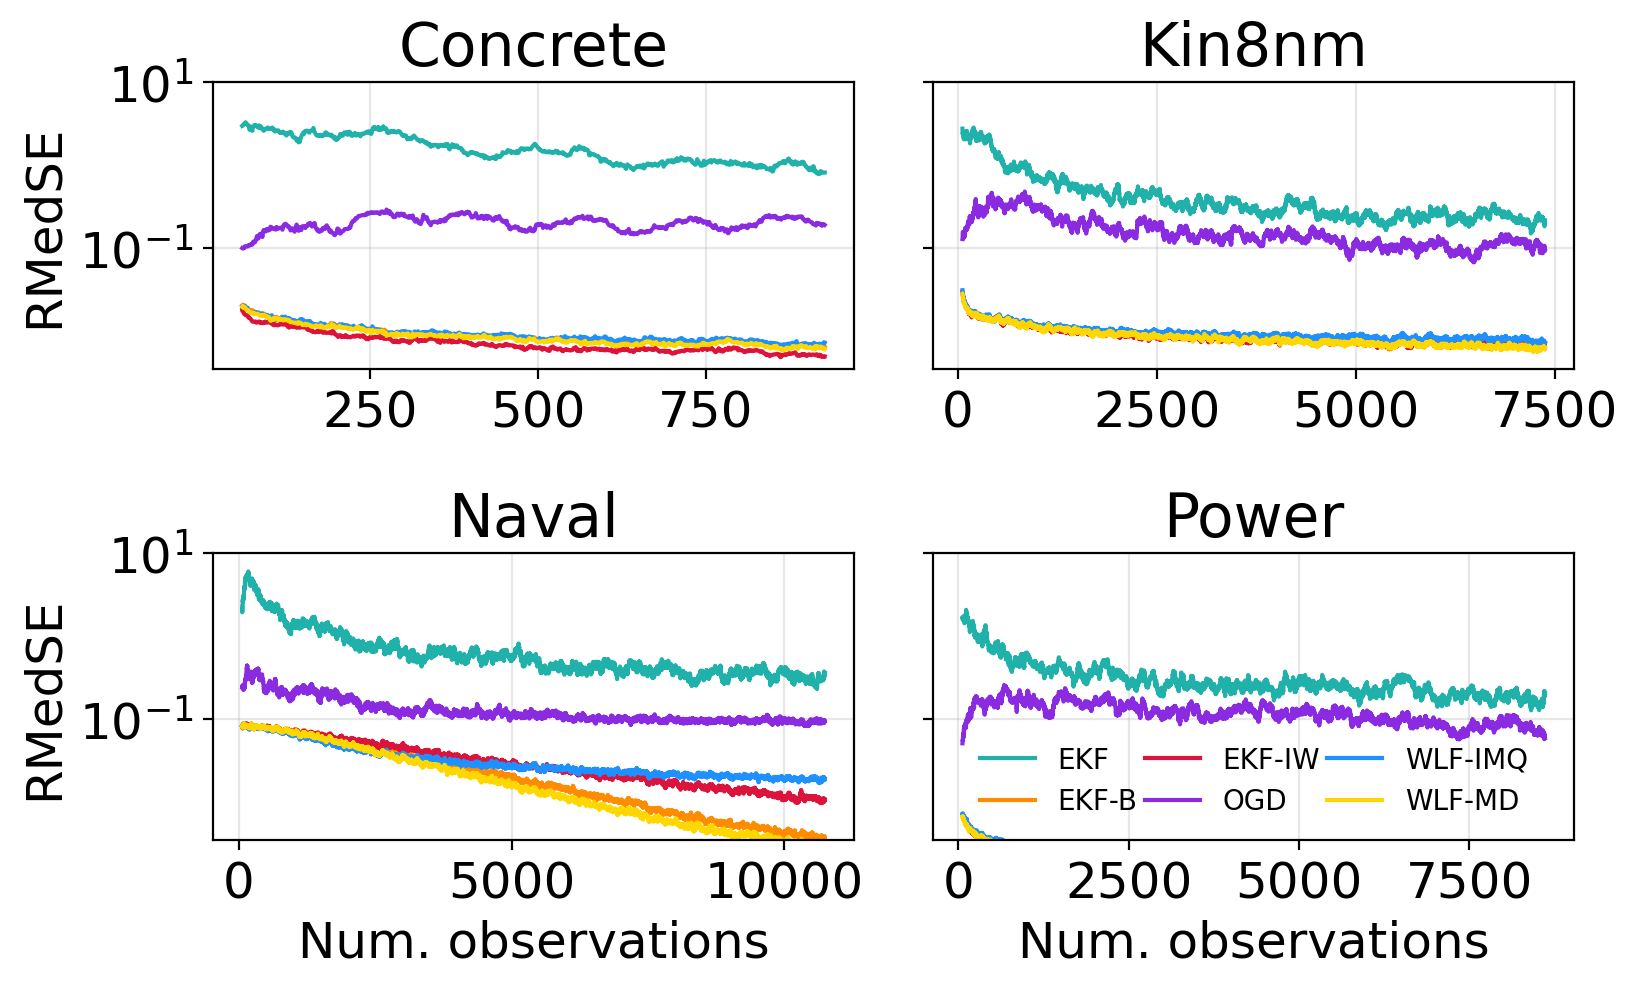

In [48]:
fig, axs = plt.subplots(2, 2, figsize=(6.4 * 1.3, 4.8 * 1.1), sharey=True)
for ax, file_name in zip(axs.ravel(), targets):
    dataset = file_name.replace("-target-p-error10.pkl", "")
    path = os.path.join(path_base, file_name)
    with open(path, "rb") as f:
        experiment = pickle.load(f)

    errors = experiment["methods"]

    for method in algorithms:
        errors[method][10:].rolling(50).median().median(axis=1).plot(label=method, c=cmap[method], ax=ax)
    ax.set_yscale("log")
    ax.grid(alpha=0.3)
    ax.set_title(re.sub("-.*", "", dataset).capitalize())
    ax.set_ylim(top=10 ** 1)
plt.subplots_adjust(
    hspace=0.6
)
axs[1, 1].legend(ncol=3, fontsize=10, columnspacing=0.25, fancybox=False, frameon=False, alignment="left")
axs[0, 0].set_ylabel("RMedSE")
axs[1, 0].set_ylabel("RMedSE")
axs[1, 0].set_xlabel("Num. observations")
axs[1, 1].set_xlabel("Num. observations")
plt.tight_layout()
plt.savefig("./figures/uci-dataset-training-error.png", dpi=300)